In [1]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch
import random
import numpy as np
import scipy.io as scp
import torch.optim as optim
import torchvision.models as models
from dataset import train_dataset, test_dataset, val_dataset

#### This notebook is referenced from https://github.com/sicara/easy-few-shot-learning/blob/master/easyfsl/samplers/task_sampler.py

In [2]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """

        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all support features vector with label i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        scores = -dists
        return scores

In [3]:
from train import eval
from model import vgg, resnet, mobilenet
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [20]:
from common_utils import EarlyStopper

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EARLY_STOP_THRESHOLD = 3
early_stopper = EarlyStopper(patience=EARLY_STOP_THRESHOLD)
convolutional_network, optimizer, criterion = mobilenet()
convolutional_network.fc = nn.Flatten()

model = PrototypicalNetworks(convolutional_network)

In [21]:
print(convolutional_network)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [22]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 5 # Number of images per class in the query set
N_TRAINING_EPISODES = 100
N_VALIDATION_TASKS = 100
N_EVALUATION_TASKS = 100


train_dataset.get_labels = lambda: [label for label in train_dataset._labels]
train_sampler = TaskSampler(
    train_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


val_dataset.get_labels = lambda: [label for label in val_dataset._labels]
val_sampler = TaskSampler(
    val_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)

val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_sampler,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

test_dataset.get_labels = lambda: [label for label in test_dataset._labels]
test_sampler = TaskSampler(
    test_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


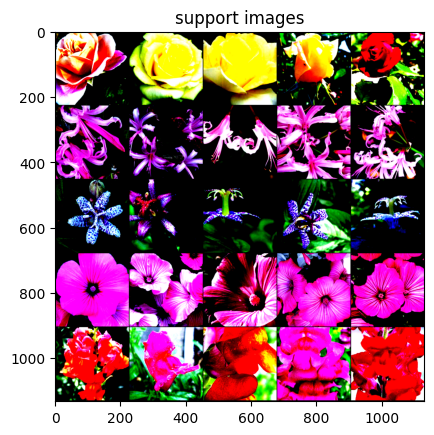

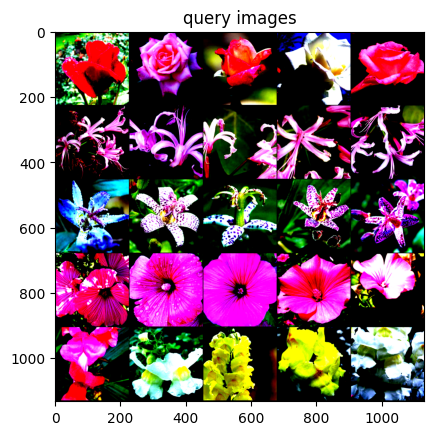

In [23]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    all_loss = []
    for episode_idx, (support_images,support_labels,query_images, query_labels,_,) in enumerate(dataloader):
        support_images, support_labels, query_images, query_labels = support_images.to(device), support_labels.to(device), query_images.to(device), query_labels.to(device)
        optimizer.zero_grad()
        output = model(support_images, support_labels, query_images)
        # print(output.shape)
        # print(output)
        loss = criterion(output, query_labels)
        loss.backward()
        optimizer.step()

        print(f'Episode {episode_idx}, Train Loss: {loss}')
        all_loss.append(loss.item())

    # return all_loss


def evaluate_on_one_task(model, criterion, support_images,support_labels,query_images,query_labels):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """

    output = model(support_images, support_labels, query_images).detach().data
    loss = criterion(output, query_labels)


    return (torch.max(output, 1,)[1] == query_labels).sum().item(), len(query_labels), loss


def evaluate(model, criterion, dataloader):
    total_predictions = 0
    correct_predictions = 0
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for episode_index, (support_images,support_labels,query_images,query_labels,_,) in enumerate(dataloader):
            correct, total, loss = evaluate_on_one_task(
                model, criterion, support_images, support_labels, query_images, query_labels
            )

            total_loss += loss
            total_predictions += total
            correct_predictions += correct

            print(f'Episode {episode_index}, Accuracy: {(100 * correct_predictions/total_predictions):.2f}%')

    print(
        f"Model tested on {len(dataloader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


In [25]:
train(model, train_loader, criterion, optimizer, DEVICE)

torch.Size([25, 5])
tensor([[-4.2603, -4.5072, -3.6910, -4.2105, -3.9824],
        [-4.2156, -4.4396, -4.1250, -4.4616, -4.5210],
        [-5.9114, -6.2366, -6.1541, -5.5118, -5.4383],
        [-5.6718, -6.1110, -6.0225, -5.5047, -5.9450],
        [-5.0678, -5.1483, -4.9267, -4.7837, -4.9242],
        [-5.8713, -5.6943, -5.4907, -5.6787, -5.7071],
        [-6.2095, -5.8160, -5.9492, -5.5344, -6.0174],
        [-5.0322, -4.8017, -4.7128, -5.0564, -4.9466],
        [-5.6869, -5.5281, -5.8542, -5.6120, -5.6891],
        [-5.4205, -4.3304, -5.4159, -5.0394, -5.3543],
        [-3.5163, -4.3159, -4.3997, -3.6826, -4.3255],
        [-4.5695, -4.9649, -4.8696, -4.9202, -4.6434],
        [-4.1759, -4.8020, -4.7166, -4.4853, -4.5304],
        [-4.2393, -4.3689, -4.4428, -4.6709, -4.3112],
        [-5.1524, -5.0715, -5.4665, -5.2086, -5.0537],
        [-5.0597, -5.6575, -5.2613, -4.9631, -5.3657],
        [-4.7369, -5.5749, -5.1747, -4.7989, -5.3375],
        [-4.9497, -5.1809, -4.7548, -4.5536, 

In [27]:
evaluate(model, criterion, val_loader)

Episode 0, Accuracy: 92.00%
Episode 1, Accuracy: 94.00%
Episode 2, Accuracy: 92.00%
Episode 3, Accuracy: 88.00%
Episode 4, Accuracy: 89.60%
Episode 5, Accuracy: 90.67%
Episode 6, Accuracy: 89.71%
Episode 7, Accuracy: 89.50%
Episode 8, Accuracy: 89.78%
Episode 9, Accuracy: 89.20%
Episode 10, Accuracy: 89.45%
Episode 11, Accuracy: 90.33%
Episode 12, Accuracy: 91.08%
Episode 13, Accuracy: 91.71%
Episode 14, Accuracy: 91.47%
Episode 15, Accuracy: 91.75%
Episode 16, Accuracy: 91.76%
Episode 17, Accuracy: 92.00%
Episode 18, Accuracy: 92.21%
Episode 19, Accuracy: 92.00%
Episode 20, Accuracy: 91.81%
Episode 21, Accuracy: 92.00%
Episode 22, Accuracy: 91.48%
Episode 23, Accuracy: 91.33%
Episode 24, Accuracy: 91.68%
Episode 25, Accuracy: 92.00%
Episode 26, Accuracy: 92.00%
Episode 27, Accuracy: 91.86%
Episode 28, Accuracy: 92.00%
Episode 29, Accuracy: 92.27%
Episode 30, Accuracy: 92.13%
Episode 31, Accuracy: 92.25%
Episode 32, Accuracy: 92.48%
Episode 33, Accuracy: 92.35%
Episode 34, Accuracy: 91

In [28]:
evaluate(model, criterion, test_loader)

Episode 0, Accuracy: 100.00%
Episode 1, Accuracy: 100.00%
Episode 2, Accuracy: 97.33%
Episode 3, Accuracy: 98.00%
Episode 4, Accuracy: 97.60%
Episode 5, Accuracy: 97.33%
Episode 6, Accuracy: 96.57%
Episode 7, Accuracy: 96.50%
Episode 8, Accuracy: 94.67%
Episode 9, Accuracy: 94.00%
Episode 10, Accuracy: 93.82%
Episode 11, Accuracy: 94.33%
Episode 12, Accuracy: 94.15%
Episode 13, Accuracy: 93.71%
Episode 14, Accuracy: 93.33%
Episode 15, Accuracy: 93.75%
Episode 16, Accuracy: 94.12%
Episode 17, Accuracy: 94.22%
Episode 18, Accuracy: 93.89%
Episode 19, Accuracy: 93.80%
Episode 20, Accuracy: 93.90%
Episode 21, Accuracy: 93.82%
Episode 22, Accuracy: 93.91%
Episode 23, Accuracy: 94.00%
Episode 24, Accuracy: 93.76%
Episode 25, Accuracy: 93.38%
Episode 26, Accuracy: 93.48%
Episode 27, Accuracy: 93.43%
Episode 28, Accuracy: 93.38%
Episode 29, Accuracy: 93.60%
Episode 30, Accuracy: 93.68%
Episode 31, Accuracy: 93.38%
Episode 32, Accuracy: 93.45%
Episode 33, Accuracy: 93.53%
Episode 34, Accuracy: 